<a href="https://colab.research.google.com/github/MorrisLesinko/Machine_Learning_Projects/blob/main/PNEUMONIA_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train categories: ['NORMAL', 'PNEUMONIA'] 0 is Pneumonia and 1 is Normal


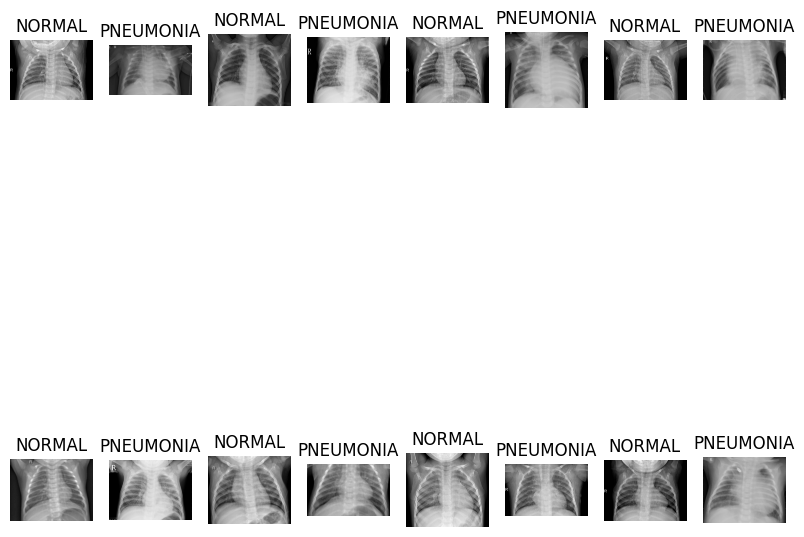

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


39/39 [==============================] - 5s 127ms/step - loss: 0.0000e+00 - accuracy: 0.6250
Test Accuracy: 0.625


'\nfrom keras.applications import MobileNet\nfrom keras.models import Model\nfrom keras.layers import Dense, GlobalAveragePooling2D\n\n# Load the MobileNet model pretrained on ImageNet without the top (fully connected) layers\nbase_model = MobileNet(weights=\'imagenet\', include_top=False, input_shape=(img_size, img_size, 3))\n\n# Add custom top layers for pneumonia classification\nx = base_model.output\nx = GlobalAveragePooling2D()(x)\nx = Dense(1024, activation=\'relu\')(x)\npredictions = Dense(1, activation=\'sigmoid\')(x)\n\n# Combine the base MobileNet model with custom top layers\nmodel = Model(inputs=base_model.input, outputs=predictions)\n\n# Freeze the layers in the base model to prevent them from being updated during training\nfor layer in base_model.layers:\n    layer.trainable = False\n\n# Compile the model\nmodel.compile(optimizer=\'adam\', loss=\'binary_crossentropy\', metrics=[\'accuracy\'])\n\n# Display model summary\nmodel.summary()\n\n\nfrom sklearn.metrics import acc

In [ ]:
#from re import X
#from google.colab import files

# Step 1: Upload kaggle.json
#uploaded = files.upload()

# Step 2: Ensure the Kaggle directory exists
#import os
#if not os.path.exists(os.path.expanduser("~/.kaggle")):
 #   os.makedirs(os.path.expanduser("~/.kaggle"))

# Move the uploaded kaggle.json file to the Kaggle directory
#for filename in uploaded.keys():
    #os.rename(filename, os.path.expanduser("~/.kaggle/kaggle.json"))

# Set permissions for the Kaggle API key
#! chmod 600 ~/.kaggle/kaggle.json

# To list all the datasets on Kaggle
#! kaggle datasets list"""

# To download a specific dataset

#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# To unzip the dataset
#!unzip \*.\zip && rm *.zip



#import pandas as pd
"""df =pd.read_csv("/content/pneumonia-detection-using-cnn-92-6-accuracy.ipynb")
df.head()"""


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np
import tensorflow as tf
import random



# Directories
Train_dir = '/content/chest_xray/train/'
Test_dir = '/content/chest_xray/test/'
Val_dir = '/content/chest_xray/val/'

# Categories
Categories = os.listdir(Train_dir)
print("Train categories:", Categories, "0 is Pneumonia and 1 is Normal")


# Step 2: Data Preprocessing
# Define image size
img_size = 150

def preprocess_data(dir):
    data = []
    for category in Categories:
        path = os.path.join(dir, category)
        class_num = Categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_img_array = cv2.resize(img_array, (img_size, img_size))
                normalized_img_array = resized_img_array / 255.0  # Normalize pixel values
                data.append([normalized_img_array, class_num])
            except Exception as e:
                pass
    return data

"""train_data = preprocess_data(Train_dir)
test_data = preprocess_data(Test_dir)
val_data = preprocess_data(Val_dir)

"""
"""pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

"""

import random

def plot_images(data_dir, categories, num_images=8):
    plt.figure(figsize=(10, 10))
    for category in categories:
        path = os.path.join(data_dir, category)
        image_files = os.listdir(path)
        for i in range(num_images):
            img_name = random.choice(image_files)
            img_path = os.path.join(path, img_name)
            img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            plt.subplot(len(categories), num_images, len(categories)*i + categories.index(category) + 1)
            plt.imshow(img_array, cmap='gray')
            plt.title(category)
            plt.axis('off')
    plt.show()

# Define categories
categories = ['NORMAL', 'PNEUMONIA']

# Plot a few random images from the NORMAL and PNEUMONIA categories
plot_images(Train_dir, categories)




# Define data generators for training, validation, and testing sets
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
    zoom_range=0.1,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest"
)



valid_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Define directories
train_dir = '/content/chest_xray/train/'
val_dir = '/content/chest_xray/val/'

# Define image size
img_size = (150, 150)

# Define batch size
batch_size = 16

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

valid_generator = valid_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)
test_generator = test_datagen.flow_from_directory(
   Test_dir ,  # Features
      target_size=(150,150),
      class_mode = 'binary',
      shuffle=True,
      seed = 42,
      batch_size=batch_size
)


"""
Model = Sequential()

Model.add(Conv2D(32, (3,3), padding = 'same', input_shape=X.shape[1:]))
Model.add(Activation('relu'))
Model.add(MaxPool2D(pool_size=(2,2)))

Model.add(Conv2D(64, (3,3), padding = 'same'))
Model.add(Activation('relu'))
Model.add(MaxPool2D(pool_size=(2,2)))

Model.add(Conv2D(96, (3,3), padding = 'same'))
Model.add(Activation('relu'))
Model.add(MaxPool2D(pool_size=(2,2)))
# Model.add(Dropout(0.2))

Model.add(Conv2D(128, (3,3), padding = 'same'))
Model.add(Activation('relu'))
Model.add(MaxPool2D(pool_size=(2,2)))
# Model.add(Dropout(0.2))

Model.add(Conv2D(256, (3,3), padding = 'same'))
Model.add(Activation('relu'))
Model.add(MaxPool2D(pool_size=(2,2)))
# Model.add(Dropout(0.2))

Model.add(Conv2D(320, (3,3), padding = 'same'))
Model.add(Activation('relu'))
Model.add(MaxPool2D(pool_size=(2,2)))
# Model.add(Dropout(0.2))

Model.add(Conv2D(320, (3,3), padding = 'same'))
Model.add(Activation('relu'))
Model.add(MaxPool2D(pool_size=(2,2)))
# Model.add(Dropout(0.2))


Model.add(Flatten())

Model.add(Dense(256))
Model.add(Activation('relu'))
# Model.add(Dropout(0.2))

Model.add(Dense(64))
Model.add(Activation('relu'))
# Model.add(Dropout(0.2))

Model.add(Dense(32))
Model.add(Activation('relu'))

Model.add(Dense(1))
Model.add(Activation('sigmoid'))

Model.summary()

Model.compile(loss = 'binary_crossentropy', optimizer = 'RMSprop', metrics=['accuracy'])

History = Model.fit(train_generator, validation_data=valid_generator, batch_size = 64, epochs = 10,validation_split = 0.1)
"""
"""

def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(150, 150, 3)
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ))
    model.add(layers.Dense(1, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', values=[1e-2, 1e-3])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

from keras import backend as K
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
# Initialize the RandomSearch tuner
tuner_search = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='output',
    project_name='chest_xray'
)

# Perform the hyperparameter search
tuner_search.search(
    train_generator,
    validation_data=valid_generator,
    epochs=3
)

# Get the best model
best_model = tuner_search.get_best_models(num_models=1)[0]
best_model.summary()

# Train the best model
history = best_model.fit(train_generator, validation_data=valid_generator, epochs=10)
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")
"""



from keras.applications import VGG19
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam

# Load the pre-trained VGG19 model without the top (fully connected) layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom top layers for pneumonia classification
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='softmax')(x)

# Combine the base VGG19 model with custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

"""
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history = model.fit(train_generator, validation_data=valid_generator,
# epochs=10)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")"""


"""
from keras.applications import MobileNet
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# Load the MobileNet model pretrained on ImageNet without the top (fully connected) layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Add custom top layers for pneumonia classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Combine the base MobileNet model with custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Generate predictions for the test set
y_pred = model.predict(test_generator).argmax(axis=1)

# Convert one-hot encoded labels of test set to integer labels
y_true = test_generator.labels

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Test Accuracy:", accuracy)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
"""

